In [1]:
import pandas as pd
import numpy as np
import csv
import math
from sklearn.linear_model import PassiveAggressiveRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime, timedelta
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# import xgboost as xgb

import constants

# Data Functions

In [2]:
def load_static_data():
    static_sensor_data=[]
    for sensor in constants.SENSOR_IDS:
        list_ = []
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/static/{}/{}.csv".format(date, sensor)
            df = pd.read_csv(filename,index_col=None)
            df['lat'] = constants.STATIC_COORDS[sensor][0]
            df['long'] = constants.STATIC_COORDS[sensor][1]
            df['mobile'] = False
            # Calibration
            df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
            df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
            df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
            df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
            df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
            # -----------
            list_.append(df)
        static_sensor_data.append(pd.concat(list_, axis = 0, ignore_index = False))
    all_static_data = pd.concat(static_sensor_data, axis = 0, ignore_index = False)
    # Select columns
    all_static_data = all_static_data[constants.COLUMNS]
    all_static_data = all_static_data.dropna()
    return all_static_data

def load_mobile_sensors():
    list_ = []
    for sensor in constants.MOBILE_SENSORS:
        for date in constants.SELECT_DATES:
            filename = "/Users/ryanegan/Documents/diss/RawData/personal/{}/{}_{}.csv".format(date, sensor, date)
            df = pd.read_csv(filename,index_col=None)
            list_.append(df)
        mobile_sensor_data = (pd.concat(list_, axis = 0, ignore_index = False))
        mobile_sensor_data['lat'] = mobile_sensor_data['latitude']
        mobile_sensor_data['long'] = mobile_sensor_data['longitude']
        mobile_sensor_data['mobile'] = True
        # Calibration
        df['PM1'] = df['PM1'].values / constants.CALIBRATION_FACTORS[sensor][0]
        df['PM2.5'] = df['PM2.5'].values / constants.CALIBRATION_FACTORS[sensor][1]
        df['PM10'] = df['PM10'].values / constants.CALIBRATION_FACTORS[sensor][2]
        df['temperature'] = df['temperature'].values / constants.CALIBRATION_FACTORS[sensor][3]
        df['humidity'] = df['humidity'].values / constants.CALIBRATION_FACTORS[sensor][4]
        #Select columns
        mobile_sensor_data = mobile_sensor_data[constants.COLUMNS]
    return mobile_sensor_data

#Transform to grid coordinates
def grid_lat_coord(lat):
    if lat < 55.93814 or lat > 55.94686:
        return -1
    i = 0
    for lat_check in np.linspace(55.93814,55.94686,constants.GRID_SIZE+1)[1:]:
        if lat < lat_check:
            return 19-i
        i+=1

def grid_long_coord(long):
    if long < -3.19665 or long > -3.18123:
        return -1
    i = 0
    for long_check in np.linspace(-3.19665,-3.18123,constants.GRID_SIZE+1)[1:]:
        if long < long_check:
            return i
        i+=1

def transform_to_grid_coordinates(data):
    data['lat_grid'] = data['lat'].apply(grid_lat_coord)
    data['long_grid'] = data['long'].apply(grid_long_coord)
    data = data[data['lat_grid'] >= 0]
    data = data[data['long_grid'] >= 0]
    return data

def setIds(data):
    startTime = constants.START_TIME
    endTime = (datetime.strptime(startTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=5)).strftime("%Y-%m-%d %H:%M:%S")
    i = 0
    j=0
    data['timestep'] = ''
    data['timestepContinuous'] = ''
    
    while startTime < constants.END_TIME:
        
        data['timestep'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), int(i), data['timestep'])
        i+=1
        
        if (data[(data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime)].shape[0] != 0):
            data['timestepContinuous'] = np.where((data['Timestamp'] >= startTime) & (data['Timestamp'] < endTime), int(j), data['timestepContinuous'])
            j+=1
        startTime = endTime
        endTime = (datetime.strptime(endTime, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=constants.WINDOW)).strftime("%Y-%m-%d %H:%M:%S")
        

# LOAD DATA

In [4]:
# staticData = load_static_data()
# staticData = transform_to_grid_coordinates(staticData)
# mobileData = load_mobile_sensors()
# mobileData = transform_to_grid_coordinates(mobileData)
# allData = pd.concat([staticData, mobileData], ignore_index=True)
# setIds(allData)
# allData


with open("all_data_15_min_50_grid.txt", "rb") as fp:   # Unpickling
    all_data = pickle.load(fp)


In [13]:
# ONLY RUN ONCE AT BEGINNING
label_grid = realValueGrid(all_data)
with open("grid_labels_50.txt", "wb") as fp:   #Pickling
    pickle.dump(label_grid, fp)

#Get true values from existing file
with open("grid_labels_50.txt", "rb") as fp:   # Unpickling
    grid_labels = pickle.load(fp)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Model Functions

In [5]:
#TODO add params for activations, num layers, width of layers, optimizer, loss function, learning rate, batch size
def createStationaryModel():
    online_model = tf.keras.Sequential([
        layers.Dense(16, activation=tf.nn.relu, input_shape=[3]),
        layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    #STOP MAKING TWO MODELS. TRAIN ONE THEN COPY IT.
    
    batch_model = tf.keras.Sequential([
        layers.Dense(16, activation=tf.nn.relu, input_shape=[3]),
        layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    online_optimizer = tf.keras.optimizers.RMSprop(0.0001)

    online_model.compile(loss='mean_squared_error',
        optimizer=online_optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])
    
    batch_optimizer = tf.keras.optimizers.RMSprop(0.0001)

    batch_model.compile(loss='mean_squared_error',
        optimizer=batch_optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])
    
    par = PassiveAggressiveRegressor(C=1, epsilon=0.1, loss='epsilon_insensitive', max_iter=100, random_state=0,tol=1e-3)
    
    return online_model, batch_model, par

# Grid Functions

In [6]:
def create_grid_with_models(grid_size):
    grid = [[] for i in range(grid_size)]
    for i, line in enumerate(grid):
        for j in range(20):
            staticCoords = list(constants.STATIC_COORDS_GRID.values())
            if ([i,j] in staticCoords):
                line.append(createStationaryModel())
            else:
                line.append(PassiveAggressiveRegressor(C=1, epsilon=0.1, loss='epsilon_insensitive', max_iter=100, random_state=0,tol=1e-3))
    return grid

def get_average_data(data):
    columns=['PM1', 'PM2.5', 'PM10', 'temperature', 'humidity', 'lat', 'long', 'lat_grid', 'long_grid', 'hour', 'timestep', 'timestepContinuous']
    allData15 = pd.DataFrame(columns=columns)
    for timestep in range(data['timestepContinuous'].max()):
        print(timestep)
        for x in range(constants.GRID_SIZE):
            for y in range(constants.GRID_SIZE):
                curData = data[(data['lat_grid'] == x) & (data['long_grid'] == y) & (data['timestepContinuous'] == timestep)]
                if(not curData.empty):
                    curData = curData.mean(axis = 0)
                    allData15.loc[len(allData15)] = curData

    return allData15
    

# Create grid with models

In [7]:
model_grid = create_grid_with_models(constants.GRID_SIZE)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# Train

In [11]:
train = all_data[all_data['timestepContinuous'] <= 1450]
valid = all_data[(all_data['timestepContinuous'] > 1450)]

# Train Functions

In [16]:
def updateModels(data, grid, labels):
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            staticCoords = list(constants.STATIC_COORDS_GRID.values())
#             print(data)
            X = data[(data['lat_grid'] == i) & (data['long_grid'] == j)]
#             print(X)
#             X = X.mean()
#             print(len(labels))
#             print(len(labels[0]))
            label = labels[0][i][j]
#             X = X[constants.TRAINING_FEATURES]
            
            #Put data in proper format
#             label = np.array([label])
            
            if ([i,j] in staticCoords and label != None and not X.empty):
                X = X[constants.TRAINING_FEATURES]
                label = np.array([label])
                online_model = grid[i][j][0]
                online_model.fit(
                    X, label, batch_size=1,
                    epochs=10, verbose=0)
                
                grid[i][j][2].partial_fit(X, label)
            
#             else:
#                 grid[i][j].partial_fit(X, labels)
                
def trainNNs(trainData, grid):
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')
                
    for coord in constants.STATIC_COORDS_GRID.values():
        labels = []
        X = pd.DataFrame(columns = constants.TRAINING_FEATURES)
        start = int(trainData['timestepContinuous'].min())
        end = int(trainData['timestepContinuous'].max())
        for i in range(start + 1, end + 1):
            curInput = trainData[(trainData['lat_grid'] == coord[0]) & (trainData['long_grid'] == coord[1]) & (trainData['timestepContinuous'] == i-1)]
            if((not curInput.empty) and (grid_labels[i][coord[0]][coord[1]] != None)):
                labels.append(grid_labels[i][coord[0]][coord[1]])
                curInput = curInput[constants.TRAINING_FEATURES]
#                 X.loc[len(X)] = curInput
                X = pd.concat([X, curInput])
        
        allData1 = trainData[(trainData['lat_grid'] == coord[0]) & (trainData['long_grid'] == coord[1]) & (trainData['timestepContinuous'] < end)]
#         USE GRID
#         train_labels = allData1.pop('nextPM')
#         X = allData1[constants.TRAINING_FEATURES]
        online_model = grid[coord[0]][coord[1]][0]
        batch_model = grid[coord[0]][coord[1]][1]
        par_model = grid[coord[0]][coord[1]][2]
        
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
        
        par_model.fit(X, labels)
        
        online_model.fit(
            X, labels, batch_size=16,
            epochs=1000, verbose=0, validation_split = .2, callbacks=[ early_stop, PrintDot()])

        history = batch_model.fit(
            X, labels, batch_size=16,
            epochs=1000, validation_split = .2, verbose=0, callbacks=[early_stop, PrintDot()])
        
        plot_history(history)
        

        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()


....................................................................................................
..................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................
....................................................................................................
....................................................................................................
....................................................................................................


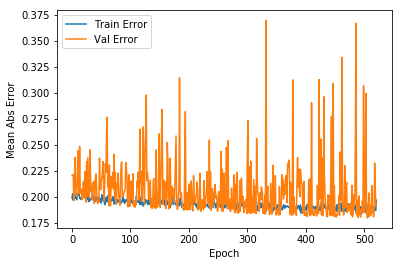

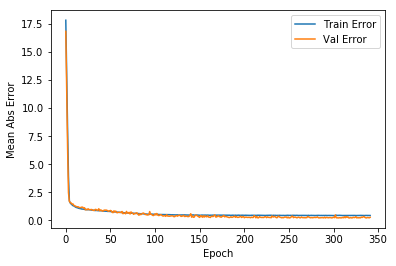

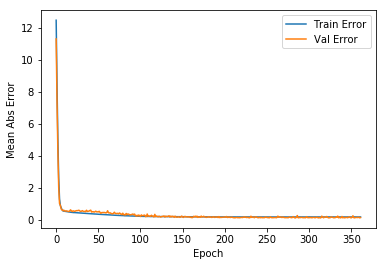

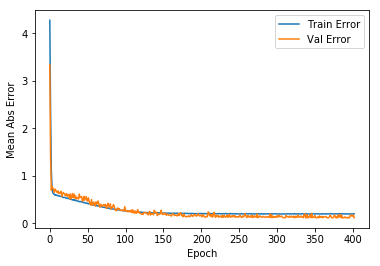

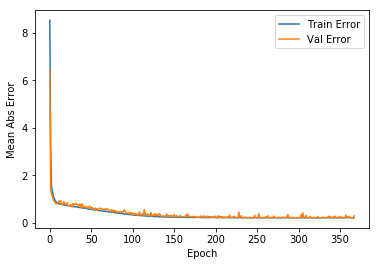

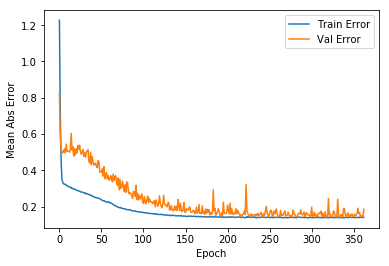

In [17]:
trainNNs(train, model_grid)


# Test Time Functions

In [12]:
def realValueGrid(data):
    values = []
    for i in range(int(data['timestepContinuous'].max())):
        print(i)
        value_matrix = [[None for x in range(constants.GRID_SIZE)] for y in range(constants.GRID_SIZE)]
        cur_data = data[data['timestepContinuous'] == i]
        #Get list of all coords
        if(not cur_data.empty):
            lat_coords = np.array(cur_data['lat_grid'])
            long_coords = np.array(cur_data['long_grid'])

            for x, y in zip(lat_coords, long_coords):
                x = int(x)
                y = int(y)

                new_label = cur_data[(cur_data['lat_grid'] == x) & (cur_data['long_grid'] == y)]['PM2.5']
                new_label = new_label.mean()
                value_matrix[x][y] = new_label
        values.append(value_matrix)
    return values

def predictOneTimestep(data, grid, timestep):
    pred_matrix = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    label_matrix = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            X = data[(data['lat_grid'] == i) & (data['long_grid'] == j)]
#             X = X.mean()
#             label = X.pop('nextPM')
            X = X[constants.TRAINING_FEATURES]
            
#             if(not X.empty):
#                 baseline = list(X[(X['lat_grid'] == coord[0]) & (X['long_grid'] == coord[1])]['PM2.5'])[0]

            label = grid_labels[timestep + 1][i][j]
            if([i,j] in constants.STATIC_COORDS_GRID.values() and not label == None and not X.empty):
                online_model = grid[i][j][0]
                batch_model = grid[i][j][1]
                par_model = grid[i][j][2]
#                 baseline = list(X[(X['lat_grid'] == coord[0]) & (X['long_grid'] == coord[1])]['PM2.5'])[0]
                
#                 baseline = X['PM2.5'].iloc[0]
                X = np.array(X)
                                
                online_pred = online_model.predict(X)
                batch_pred = batch_model.predict(X)
                par_pred = par_model.predict(X)
#                 pred_matrix[i][j] = (online_pred[0][0], batch_pred[0][0], label, par_pred[0], baseline)

                pred_matrix[i][j] = (online_pred[0][0], batch_pred[0][0], label, par_pred[0])
#             else:
#                 #do par predict
                
    online_pred_matrix = interpolate(pred_matrix, 0)
    batch_pred_matrix = interpolate(pred_matrix, 1)
    par_pred_matrix = interpolate(pred_matrix, 3)
    label_matrix = grid_labels[timestep + 1]
    return (online_pred_matrix, batch_pred_matrix, par_pred_matrix, label_matrix)

def interpolate(pred_matrix, pred_type):

    #PLACE CNN HERE
    data = np.array([[coord[0], coord[1], pred_matrix[coord[0]][coord[1]][pred_type]] for coord in constants.STATIC_COORDS_GRID.values() if len(pred_matrix[coord[0]][coord[1]]) > 0])
    print(data[:,1])
    ok = OrdinaryKriging(data[:,0], data[:,1], data[:,2], variogram_model='gaussian', verbose=False, enable_plotting=False)
    gridx = np.arange(0.0, constants.GRID_SIZE, 1)
    gridy = np.arange(0.0, constants.GRID_SIZE, 1)
    z, ss = ok.execute('grid', gridx, gridy)
    return z
    

def getFullPredictions(grid, data):
    minValue = int(data['timestepContinuous'].min())
    maxValue = int(data['timestepContinuous'].max())
    online_predictions = []
    batch_predictions = []
    ensemble = []
    ensemble2 = []
    ensemble3 = []
    par_predictions = []
    baseline_predictions = []
    all_labels = []
#     online_predictions = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
#     batch_predictions = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
#     ensemble = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
#     ensemble2 = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
#     ensemble3 = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
#     par_predictions = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
#     baseline_predictions = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
    
#     labels = [[[] for x in range(len(grid))] for y in range(len(grid[0]))]
   
    for timestep in range(minValue, maxValue):
#     for timestep in range(1522, 1523):
        print(timestep)
        newData = data[(data['timestepContinuous'] == timestep)]
        newData = newData[constants.FEATURES].dropna()
        
        online_pred_matrix, batch_pred_matrix, par_pred_matrix, label_matrix = predictOneTimestep(newData, model_grid, timestep)
        online_predictions.append(online_pred_matrix)
        batch_predictions.append(batch_pred_matrix)
        par_predictions.append(par_pred_matrix)
        
        ensemble_pred = (.5 * online_pred_matrix) + (.5 * par_pred_matrix)
        ensemble_pred2 = (.5 * par_pred_matrix) + (.5 * batch_pred_matrix)
        ensemble_pred3 = (.5 * online_pred_matrix) + (.5 * batch_pred_matrix)
        
        ensemble.append(ensemble_pred)
        ensemble2.append(ensemble_pred2)
        ensemble3.append(ensemble_pred3)
        
        all_labels.append(label_matrix)
        
        updateModels(newData, model_grid, all_labels)
    
    return (online_predictions, batch_predictions, ensemble, ensemble2, ensemble3, all_labels, par_predictions, baseline_predictions)

def getValidationError(preds, data):
    minValue = int(data['timestepContinuous'].min())
    maxValue = int(data['timestepContinuous'].max())
#     values =  [[3, 6], [16, 6], [8, 5], [13, 13]', '[3, 10]', '[8, 13]']
    labels_to_eval = []
    preds_to_eval = []


    for i, timestep in enumerate(range(minValue, maxValue)):
        testData = data[(data['timestepContinuous'] == timestep)]
        if(not testData.empty):
            for x in range(constants.GRID_SIZE):
                for y in range(constants.GRID_SIZE):
                    if(timestep + 1 < maxValue and (not grid_labels[timestep + 1][x][y] is None)):
                        if([x,y] not in constants.STATIC_COORDS_GRID.values()):
                            labels_to_eval.append(grid_labels[timestep + 1][x][y])
                            preds_to_eval.append(preds[i][x][y])

#     plot_preds(preds_to_eval, labels_to_eval)
    print(mean_absolute_error(preds_to_eval, labels_to_eval))
    return mean_absolute_error(preds_to_eval, labels_to_eval)


In [21]:
online_preds, batch_preds, ensemble_preds, ensemble_preds2, ensemble_preds3, labels, par_preds, baseline_preds = getFullPredictions(model_grid, valid)
onlineError = getValidationError(online_preds, valid)
for i in range(10):
    print(mean_absolute_error(baseline_preds[i], labels[i]))
    print(mean_absolute_error(online_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(batch_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(ensemble_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(ensemble_preds2[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(ensemble_preds3[coord[0]][coord[1]], labels[coord[0]][coord[1]]))
    print(mean_absolute_error(par_preds[coord[0]][coord[1]], labels[coord[0]][coord[1]]))

1451
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
1452
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
1453
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
1454
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
1455
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
[ 6.  6.  5. 13. 10. 13.]
1456

KeyboardInterrupt: 

In [ ]:
onlineError = getValidationError(online_preds, valid)
batchError = getValidationError(batch_preds, valid)
# onlineError = getValidationError(baseline_preds, labels, valid)
parError = getValidationError(par_preds, valid)
onlineError = getValidationError(ensemble_preds, valid)
onlineError = getValidationError(ensemble_preds2, valid)
onlineError = getValidationError(ensemble_preds3, valid)

In [ ]:
def plot_preds(preds, labels):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

    x = range(len(preds))
    plt.figure()
    plt.xlabel('Timestep')
    plt.ylabel('PM 2.5')
    plt.plot(x, preds,
           label='Predictions')
    plt.plot(x, labels,
           label = 'True Value')
    plt.ylim([0,5])
    plt.legend()

    plt.show()

In [ ]:
all_online_preds = []
all_batch_preds = []
all_par_preds = []
all_ensemble_preds = []
all_ensemble_preds2 = []
all_ensemble_preds3 = []
all_labels = []
all_baseline = []
for coord in constants.STATIC_COORDS_GRID.values():
    all_baseline = all_baseline + baseline_preds[coord[0]][coord[1]]
    all_online_preds = all_online_preds + online_preds[coord[0]][coord[1]]
    all_batch_preds = all_batch_preds + batch_preds[coord[0]][coord[1]]
    all_par_preds = all_par_preds + par_preds[coord[0]][coord[1]]
    all_ensemble_preds = all_ensemble_preds + ensemble_preds[coord[0]][coord[1]]
    all_ensemble_preds2 = all_ensemble_preds2 + ensemble_preds2[coord[0]][coord[1]]
    all_ensemble_preds3 = all_ensemble_preds3 + ensemble_preds3[coord[0]][coord[1]]
    all_labels = all_labels + labels[coord[0]][coord[1]]  
                                 
print(mean_absolute_error(all_baseline, all_labels))
print(mean_absolute_error(all_online_preds, all_labels))
print(mean_absolute_error(all_batch_preds, all_labels))
print(mean_absolute_error(all_par_preds, all_labels))
print(mean_absolute_error(all_ensemble_preds, all_labels))
print(mean_absolute_error(all_ensemble_preds2, all_labels))
print(mean_absolute_error(all_ensemble_preds3, all_labels))

In [ ]:
# for timestep in range(4000, 4000 + len(valid['timestepContinuous'].unique())):
for timestep in range(4000, 4000 + 5):

    
    #to_insert IS NEW DATA AT GIVEN TIME
    to_predict = valid[valid['timestepContinuous'] == timestep]
#     if mobile_sensor_data is not None:
#         to_insert = to_insert.append( mobile_sensor_data[(mobile_sensor_data['Timestamp'] > start_window) & (mobile_sensor_data['Timestamp'] < end_window)])
#     to_insert = to_insert.groupby(['lat_grid','long_grid']).mean()
#     to_insert.reset_index(level=to_insert.index.names, inplace=True)
    z = [[0 for j in range(constants.GRID_SIZE)] for i in range(constants.GRID_SIZE)]

    #PLACE CNN HERE
    ok = OrdinaryKriging(to_predict['long_grid'], to_predict['lat_grid'], to_predict['PM2.5'], variogram_model='gaussian', verbose=False, enable_plotting=False)
    gridx = np.arange(0.0, 20, 1)
    gridy = np.arange(0.0, 20, 1)
    z, ss = ok.execute('grid', gridx, gridy)
    # Substituto do Kriging so com os valores lidos
    # Com ambos a funcionar, isto faz a correção dos erros do Kriging presente
#     for index, row in to_predict.iterrows():
#         z[int(row['lat_grid'])][int(row['long_grid'])] = row['PM2.5']
#         hour[int(row['lat_grid'])][int(row['long_grid'])] = row['hour']
    
    updateModels(model_grid, timestep, valid)
    

In [ ]:
grid_labels[1222]